**Lab2-DL: C3-cnn-testing-gradcam.ipynb** (ELMED219) | Prioritet: 2 (anbefalt)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/C3-cnn-testing-gradcam.ipynb)

# 🧪 C3: CNN Testing og Evaluering

**Fra Natur til Medisin: Test og Evaluer CNN-modellen**

---

## 🎯 Mål for denne delen

I denne notebooken skal vi:
- **Laste inn** trent modell fra del 2
- **Teste** modellen på testsettet
- **Evaluer** ytelse med forvirringsmatrise og metrikker
- **Forstå** modellens beslutninger med forklarbar AI
- **Sammenligne** med medisinsk bildeanalyse

## Forutsetninger

Denne notebooken bygger på `C2-cnn-trening.ipynb`. Sørg for at du har:
- ✅ Fullført del 2
- ✅ Lagret trent modell
- ✅ Forstått treningsprosessen

## 🔧 Miljøoppsett

Vi starter med å sette opp miljøet og laste inn nødvendige biblioteker.

In [1]:
import sys
import subprocess
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Kjører i Google Colab")
    
    # Installer nødvendige pakker
    !pip install seaborn --quiet
    
    # Sjekk om mappen allerede eksisterer
    if not os.path.exists('ELMED219-2026/Lab2-DL'):
        print(" Laster ned kursmateriell...")
        try:
            !git clone https://github.com/arvidl/ELMED219-2026.git
            os.chdir('ELMED219-2026/Lab2-DL')
        except:
            print("❌ Kunne ikke laste ned kursmateriell")
            print("Last ned manuelt fra: https://github.com/arvidl/ELMED219-2026")
else:
    print("💻 Kjører lokalt eller i Codespaces")
    
print("✅ Miljøoppsett fullført!")

💻 Kjører lokalt eller i Codespaces
✅ Miljøoppsett fullført!


In [1]:
# Importer nødvendige biblioteker
from PIL import Image  # Viktig: Må importeres FØST for å unngå navnekonflikt
from IPython.display import Image as IPyImage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import time
import cv2
import warnings
warnings.filterwarnings('ignore')

# Sett random seeds for reproduserbarhet
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("📚 Biblioteker importert!")

📚 Biblioteker importert!


In [2]:
# Konfigurer enhet (CPU, GPU, eller MPS)
def setup_device():
    """Sett opp best tilgjengelig enhet"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"🚀 Bruker GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("🍎 Bruker MPS (Apple Silicon)")
    else:
        device = torch.device('cpu')
        print("💻 Bruker CPU")
    
    return device

device = setup_device()
print(f"✅ Enhet satt til: {device}")

🍎 Bruker MPS (Apple Silicon)
✅ Enhet satt til: mps


## Last inn trent modell og data

Vi laster inn den trente modellen og dataene som ble lagret i del 2.

In [3]:
# Last inn data-info fra del 1
try:
    with open('flower_data_info.pkl', 'rb') as f:
        data_info = pickle.load(f)
    
    # Pakk ut data
    X_train = data_info['X_train']
    y_train = data_info['y_train']
    X_val = data_info['X_val']
    y_val = data_info['y_val']
    X_test = data_info['X_test']
    y_test = data_info['y_test']
    class_names = data_info['class_names']
    class_mapping = data_info['class_mapping']
    num_classes = data_info['num_classes']
    
    print("✅ Data lastet inn fra del 1!")
    print(f"📊 Treningssett: {len(X_train)} bilder")
    print(f" Valideringssett: {len(X_val)} bilder")
    print(f"📊 Testsett: {len(X_test)} bilder")
    print(f" Klasser: {class_names}")
    
except FileNotFoundError:
    print("❌ Kunne ikke finne 'flower_data_info.pkl'")
    print("💡 Sørg for at du har fullført del 1 først!")
    print(" Kjør '02a_cnn_bildeklassifikasjon.ipynb' først")
    raise

✅ Data lastet inn fra del 1!
📊 Treningssett: 2569 bilder
 Valideringssett: 550 bilder
📊 Testsett: 551 bilder
 Klasser: ['Tusenfryd', 'Løvetann', 'Rose', 'Solsikke', 'Tulipan']


In [4]:
# Last inn trent modell
try:
    checkpoint = torch.load('trained_flower_model.pth', map_location=device)
    
    # Last inn treningshistorikk
    with open('training_history.pkl', 'rb') as f:
        training_history = pickle.load(f)
    
    print("✅ Trent modell lastet inn!")
    print(f"🏗️ Modellarkitektur: {checkpoint['model_architecture']}")
    print(f"📊 Antall klasser: {checkpoint['num_classes']}")
    print(f" Beste validerings-accuracy: {training_history['best_val_acc']:.2f}%")
    
except FileNotFoundError:
    print("❌ Kunne ikke finne trent modell")
    print("💡 Sørg for at du har fullført del 2 først!")
    print(" Kjør '02b_cnn_trening.ipynb' først")
    raise

✅ Trent modell lastet inn!
🏗️ Modellarkitektur: SimpleCNN
📊 Antall klasser: 5
 Beste validerings-accuracy: 74.18%


In [5]:
# Definer transformasjoner (samme som i del 1)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Transformasjoner definert!")

✅ Transformasjoner definert!


In [6]:
# Custom Dataset klasse (samme som i del 1)
class FlowerDataset(Dataset):
    """Custom dataset for blomsterbilder"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Last bilde
        image = Image.open(image_path).convert('RGB')
        
        # Anvend transform
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Opprett test dataset og DataLoader
test_dataset = FlowerDataset(X_test, y_test, val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"✅ Test DataLoader opprettet")
print(f"  Testbatcher: {len(test_loader)}")
print(f"  Testbilder: {len(test_dataset)}")

✅ Test DataLoader opprettet
  Testbatcher: 18
  Testbilder: 551


In [7]:
# Last inn modellarkitektur
class SimpleCNN(nn.Module):
    """Enkel CNN for blomsterklassifikasjon"""
    
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        
        # Konvolusjonslag
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout for regularisering
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected lag
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Konvolusjonsblokk 1
        x = self.pool(torch.relu(self.conv1(x)))
        
        # Konvolusjonsblokk 2
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Konvolusjonsblokk 3
        x = self.pool(torch.relu(self.conv3(x)))
        
        # Flatten for fully connected lag
        x = x.view(-1, 128 * 28 * 28)
        
        # Fully connected lag
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Opprett modell og last inn vekter
model = SimpleCNN(num_classes=num_classes)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()  # Sett i evalueringsmodus

print("✅ Modell lastet inn og satt i evalueringsmodus!")
print(f"🏗️ Modellarkitektur: {model.__class__.__name__}")
print(f"📊 Antall parametere: {sum(p.numel() for p in model.parameters()):,}")

✅ Modell lastet inn og satt i evalueringsmodus!
🏗️ Modellarkitektur: SimpleCNN
📊 Antall parametere: 51,476,549


## Testing av modellen

Nå tester vi modellen på testsettet og samler prediksjoner.

In [8]:
def evaluate_model(model, test_loader, device, class_names):
    """Evaluer modellen på testsettet"""
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    print(" Tester modellen på testsettet...")
    print("⏳ Dette kan ta noen minutter...")
    
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            # Gjør prediksjoner
            outputs = model(data)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            # Samle resultater
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # Vis progress
            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch {batch_idx + 1}/{len(test_loader)} fullført")
    
    test_time = time.time() - start_time
    
    # Konverter til numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    
    # Beregn accuracy
    accuracy = (all_predictions == all_labels).mean() * 100
    
    print(f"\n✅ Testing fullført!")
    print(f"⏱️ Testtid: {test_time:.1f} sekunder")
    print(f" Test-accuracy: {accuracy:.2f}%")
    
    return all_predictions, all_labels, all_probabilities, accuracy

# Test modellen
predictions, labels, probabilities, test_accuracy = evaluate_model(model, test_loader, device, class_names)

 Tester modellen på testsettet...
⏳ Dette kan ta noen minutter...
  Batch 10/18 fullført

✅ Testing fullført!
⏱️ Testtid: 4.3 sekunder
 Test-accuracy: 74.05%


## Forvirringsmatrise og metrikker

La oss analysere modellens ytelse med forvirringsmatrise og detaljerte metrikker.

📊 Genererer forvirringsmatrise...


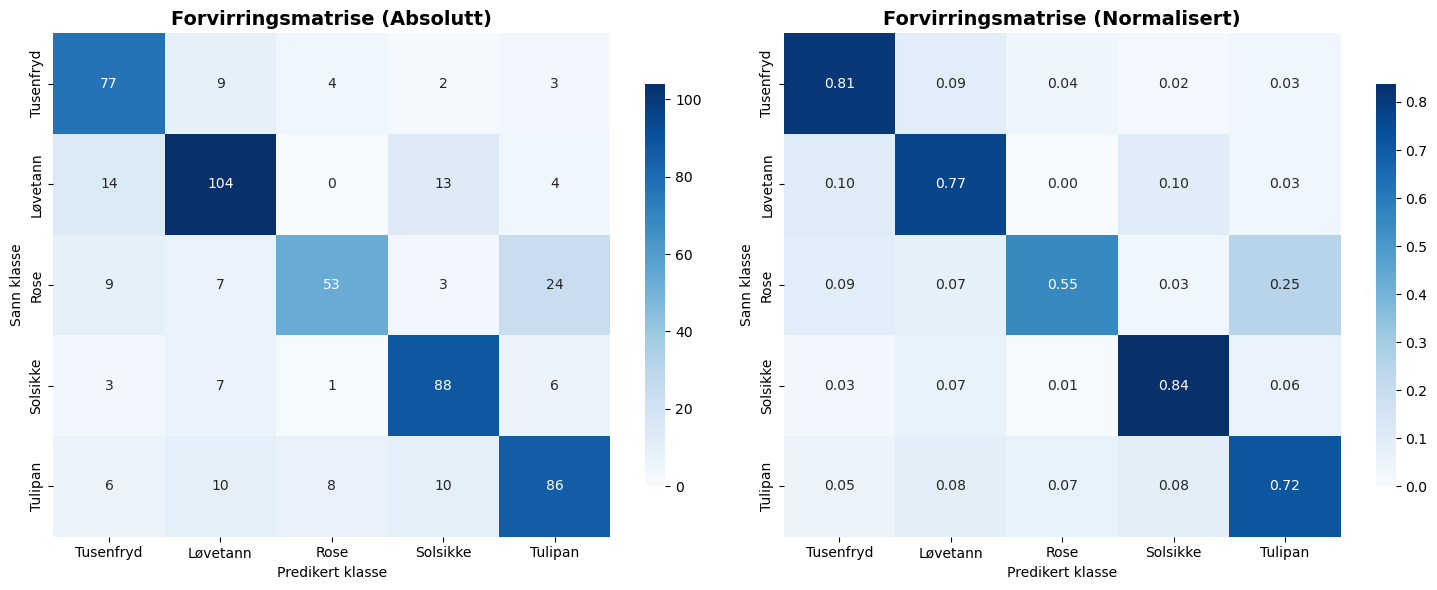

In [9]:
def plot_confusion_matrix(labels, predictions, class_names):
    """Plot forvirringsmatrise"""
    
    # Beregn forvirringsmatrise
    cm = confusion_matrix(labels, predictions)
    
    # Normaliser forvirringsmatrise
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Opprett subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Absolutt forvirringsmatrise
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'shrink': 0.8})
    axes[0].set_title('Forvirringsmatrise (Absolutt)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predikert klasse')
    axes[0].set_ylabel('Sann klasse')
    
    # Normalisert forvirringsmatrise
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'shrink': 0.8})
    axes[1].set_title('Forvirringsmatrise (Normalisert)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predikert klasse')
    axes[1].set_ylabel('Sann klasse')
    
    plt.tight_layout()
    plt.show()
    
    return cm, cm_normalized

# Plot forvirringsmatrise
print("📊 Genererer forvirringsmatrise...")
cm, cm_normalized = plot_confusion_matrix(labels, predictions, class_names)

In [10]:
def print_detailed_metrics(labels, predictions, class_names):
    """Print detaljerte metrikker"""
    
    print(" Detaljerte metrikker:")
    print("=" * 60)
    
    # Classification report
    report = classification_report(labels, predictions, target_names=class_names, output_dict=True)
    
    # Print per-klasse metrikker
    print("\n Per-klasse metrikker:")
    print("-" * 40)
    
    for i, class_name in enumerate(class_names):
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        
        print(f"{class_name:12}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support}")
    
    # Print overall metrikker
    print("\n Overall metrikker:")
    print("-" * 40)
    print(f"Accuracy:  {report['accuracy']:.3f}")
    print(f"Macro Avg: Precision={report['macro avg']['precision']:.3f}, Recall={report['macro avg']['recall']:.3f}, F1={report['macro avg']['f1-score']:.3f}")
    print(f"Weighted Avg: Precision={report['weighted avg']['precision']:.3f}, Recall={report['weighted avg']['recall']:.3f}, F1={report['weighted avg']['f1-score']:.3f}")
    
    return report

# Print detaljerte metrikker
metrics_report = print_detailed_metrics(labels, predictions, class_names)

 Detaljerte metrikker:

 Per-klasse metrikker:
----------------------------------------
Tusenfryd   : Precision=0.706, Recall=0.811, F1=0.755, Support=95.0
Løvetann    : Precision=0.759, Recall=0.770, F1=0.765, Support=135.0
Rose        : Precision=0.803, Recall=0.552, F1=0.654, Support=96.0
Solsikke    : Precision=0.759, Recall=0.838, F1=0.796, Support=105.0
Tulipan     : Precision=0.699, Recall=0.717, F1=0.708, Support=120.0

 Overall metrikker:
----------------------------------------
Accuracy:  0.740
Macro Avg: Precision=0.745, Recall=0.738, F1=0.736
Weighted Avg: Precision=0.745, Recall=0.740, F1=0.737


## Forklarbar AI - Grad-CAM (Class Activation Maps)

La oss forstå hvilke deler av bildene modellen fokuserer på ved vise original-bilde, Grad-CAM heatmap og overlay.

Grad-CAM fungerer ved å:
- Beregne gradienter for den predikerte klassen
- Vise hvilke deler av bildet som påvirker prediksjonen mest
- Gi røde områder = viktige for prediksjonen
- Gi blå områder = mindre viktige

Dette gir en mer informativ forståelse av hva modellen fokuserer på ...

🔍 Tester Grad-CAM på 4 eksempelbilder...

📸 Bilde 1/4
------------------------------


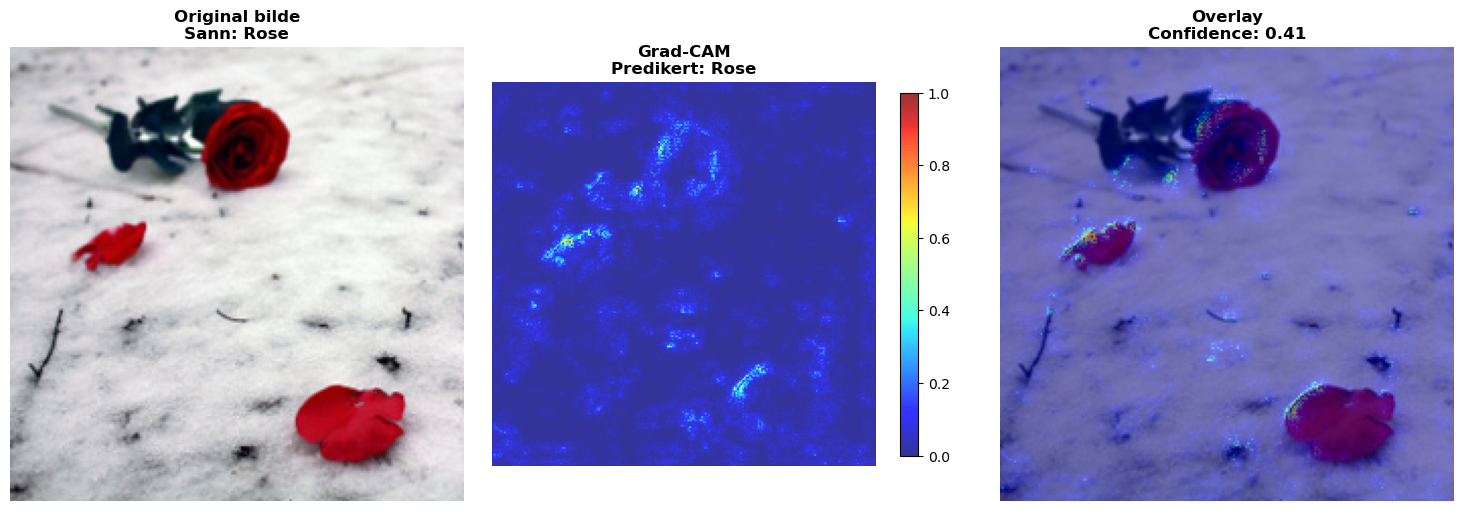

Resultat: ✅
Sann klasse: Rose
Predikert: Rose
Confidence: 0.41

📸 Bilde 2/4
------------------------------


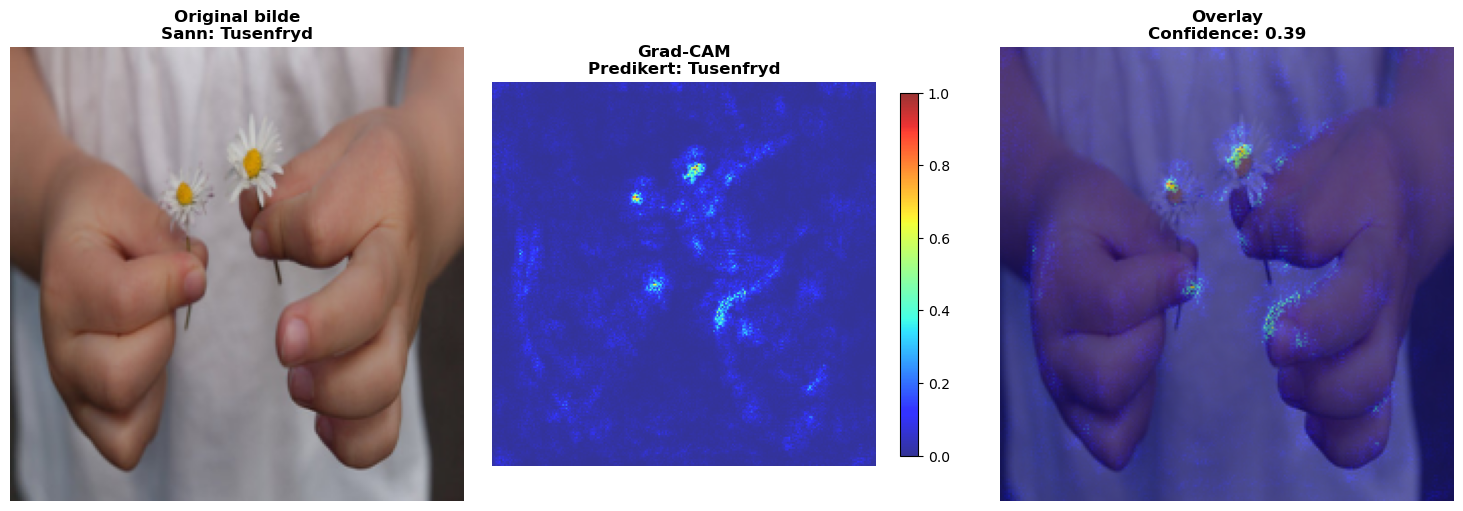

Resultat: ✅
Sann klasse: Tusenfryd
Predikert: Tusenfryd
Confidence: 0.39

📸 Bilde 3/4
------------------------------


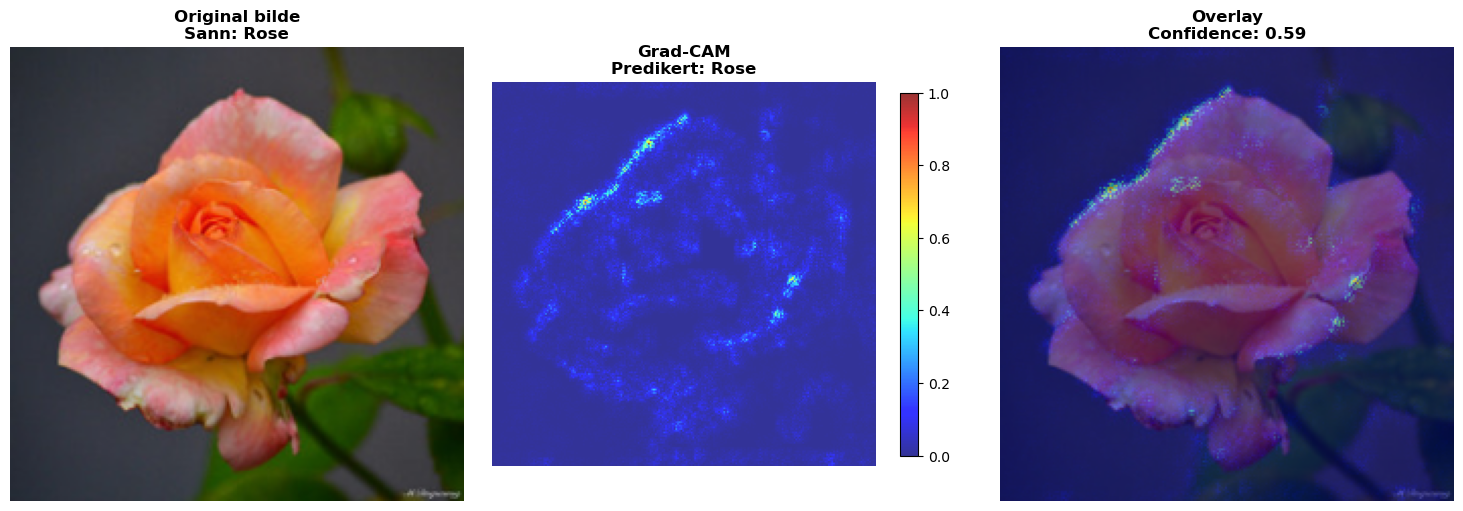

Resultat: ✅
Sann klasse: Rose
Predikert: Rose
Confidence: 0.59

📸 Bilde 4/4
------------------------------


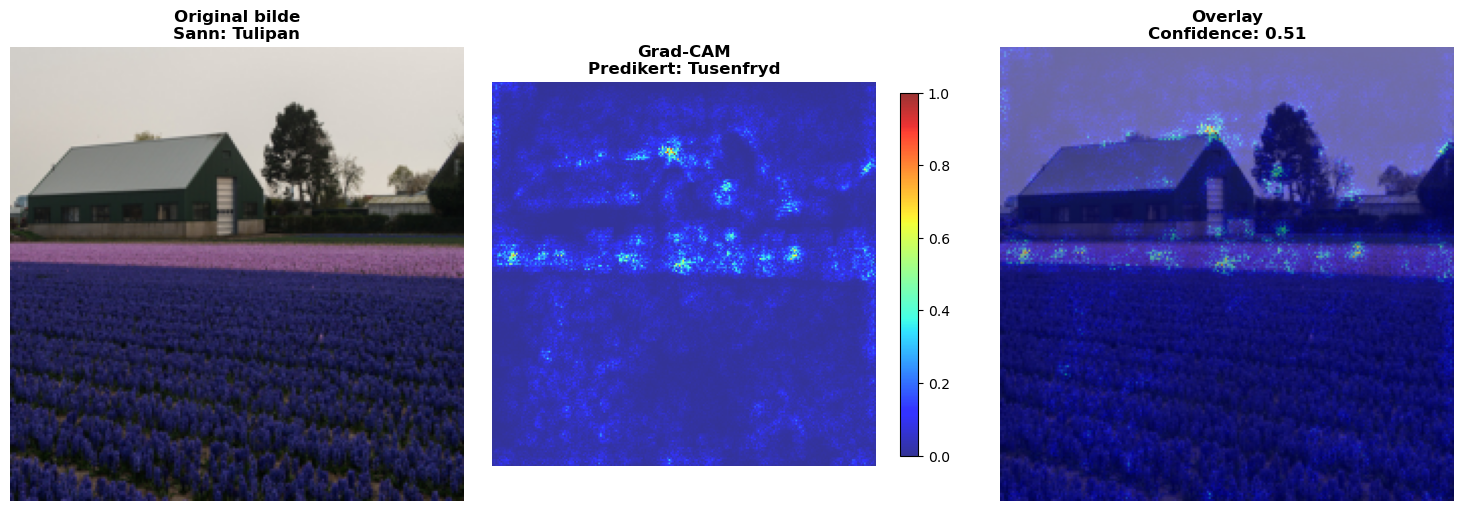

Resultat: ❌
Sann klasse: Tulipan
Predikert: Tusenfryd
Confidence: 0.51
⚠️ Feilklassifikasjon!


In [11]:
def generate_grad_cam(model, image, class_idx, device):
    """Generer Grad-CAM for et bilde"""
    
    model.eval()
    
    # Hent feature maps fra siste konvolusjonslag
    features = None
    def hook_fn(module, input, output):
        nonlocal features
        features = output
    
    # Registrer hook på siste konvolusjonslag
    hook = model.conv3.register_forward_hook(hook_fn)
    
    # Sett input til å kreve gradient
    image = image.unsqueeze(0).to(device)
    image.requires_grad_(True)
    
    # Gjør prediksjon
    output = model(image)
    predicted_class = torch.argmax(output, dim=1).item()
    confidence = torch.softmax(output, dim=1)[0][predicted_class].item()
    
    # Beregn gradient for den predikerte klassen
    model.zero_grad()
    output[0, predicted_class].backward()
    
    # Hent gradient for input bildet
    gradients = image.grad.data[0].cpu()  # Shape: (3, 224, 224)
    
    # Generer Grad-CAM ved å ta gjennomsnitt av gradienter over kanaler
    grad_cam = torch.mean(torch.abs(gradients), dim=0)  # Shape: (224, 224)
    
    # Normaliser Grad-CAM
    if grad_cam.max() > grad_cam.min():
        grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())
    
    # Fjern hook
    hook.remove()
    
    return grad_cam.numpy(), predicted_class, confidence

def plot_grad_cam_visualization(image, grad_cam, predicted_class, true_class, class_names, confidence):
    """Visualiser Grad-CAM resultater"""
    
    # Denormaliser bilde for visualisering
    img = image.clone()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()
    
    # Opprett subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original bilde
    axes[0].imshow(img)
    axes[0].set_title(f'Original bilde\nSann: {class_names[true_class]}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Grad-CAM
    im = axes[1].imshow(grad_cam, cmap='jet', alpha=0.8)
    axes[1].set_title(f'Grad-CAM\nPredikert: {class_names[predicted_class]}', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], shrink=0.8)
    
    # Overlay
    axes[2].imshow(img)
    axes[2].imshow(grad_cam, cmap='jet', alpha=0.5)
    axes[2].set_title(f'Overlay\nConfidence: {confidence:.2f}', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

def test_grad_cam_samples(model, test_loader, class_names, num_samples=4):
    """Test Grad-CAM på eksempelbilder"""
    
    print(f"🔍 Tester Grad-CAM på {num_samples} eksempelbilder...")
    print("=" * 60)
    
    # Hent en batch fra testsettet
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    # Ta bare de første num_samples bildene
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    for i in range(num_samples):
        image = images[i]
        true_class = labels[i].item()
        
        print(f"\n📸 Bilde {i+1}/{num_samples}")
        print("-" * 30)
        
        # Generer Grad-CAM
        grad_cam, predicted_class, confidence = generate_grad_cam(model, image, true_class, device)
        
        # Visualiser
        plot_grad_cam_visualization(image, grad_cam, predicted_class, true_class, class_names, confidence)
        
        # Vis resultater
        correct = "✅" if predicted_class == true_class else "❌"
        print(f"Resultat: {correct}")
        print(f"Sann klasse: {class_names[true_class]}")
        print(f"Predikert: {class_names[predicted_class]}")
        print(f"Confidence: {confidence:.2f}")
        
        if predicted_class != true_class:
            print(f"⚠️ Feilklassifikasjon!")

# Test Grad-CAM på 4 eksempelbilder
test_grad_cam_samples(model, test_loader, class_names, num_samples=4)

In [12]:
# Vis eksempelbilde av Grad-CAM resultater
# Note: Vi bruker IPyImage (aliased earlier) for å unngå konflikt med PIL.Image
from IPython.display import display

print("\n🖼️ Grad-CAM resultater for blomsterklassifikasjon:")
display(IPyImage(filename='./ressurser/Grad-CAM_blomsterklassifikasjon.png'))



🖼️ Grad-CAM resultater for blomsterklassifikasjon:


FileNotFoundError: [Errno 2] No such file or directory: './ressurser/Grad-CAM_blomsterklassifikasjon.png'

Vi lar en AI (claude-4-sonnet) diskutere bruken av Grad-CAM for forklarbar AI i hvert av de fire eksemplene (figuren over) og trekker sammenligninger mellom natur og medisin:

### Grad-CAM Analyse: Fra Blomster til Medisin

#### **Eksempel 1: Løvetann (Dandelion)**
**Grad-CAM Resultat:** Modellen fokuserer på den sentrale, sfæriske delen av løvetannfrøhodet.

**Forklarbar AI-analyse:**
- ✅ **Korrekt fokus**: Modellen identifiserer de karakteristiske trekkene som definerer en løvetann
- ✅ **Høy tillit**: Confidence på 0.91 indikerer sterk sikkerhet
- ✅ **Konsistent mønster**: Rød/gul aktivering på de viktigste strukturene

**Medisinsk sammenligning:**
I medisinsk bildeanalyse tilsvarer dette en modell som korrekt identifiserer en patologi (f.eks. tumor i MRI) ved å fokusere på den faktiske lesjonen. Dette bygger tillit hos klinikere ved å vise at AI-en "ser på riktig sted" og ikke baserer diagnosen på bakgrunnsstøy eller artefakter.

---

#### **Eksempel 2: Solsikke (Sunflower)**
**Grad-CAM Resultat:** Sterk fokus på solsikkeblomstene, ikke på vinflasken eller lyset.

**Forklarbar AI-analyse:**
- ✅ **Robust klassifikasjon**: Modellen ignorerer distraksjoner (vin, lys)
- ✅ **Korrekt prioritering**: Fokuserer på hovedobjektet
- ⚠️ **Moderat tillit**: Confidence på 0.70 er lavere enn forventet

**Medisinsk sammenligning:**
Dette er kritisk i medisinsk AI! Hvis en modell skal detektere en sykdom, må Grad-CAM vise at den fokuserer på den faktiske patologien, ikke på pasientidentifikatorer, bilderammer eller andre irrelevante strukturer. En modell som predikerer "lungebetennelse" men fokuserer på ribbeina i stedet for lungeinfiltrater, signaliserer en kritisk feil.

---

#### **Eksempel 3: Tusenfryd (Daisies)**
**Grad-CAM Resultat:** Spredte, mindre aktiveringer på hver enkelt tusenfryd.

**Forklarbar AI-analyse:**
- ✅ **Distribuert gjenkjenning**: Modellen identifiserer flere forekomster
- ✅ **Konsistent mønster**: Hver blomst får sin egen aktivering
- ✅ **Skalerbarhet**: Fungerer med mange små objekter

**Medisinsk sammenligning:**
Dette tilsvarer sykdommer karakterisert av multiple, små funn som:
- **Mikrokalkulasjoner** i mammografi
- **Diffuse infiltrater** i lunge-scanning
- **Multipl sklerose-lesjoner** i hjerne-MRI

Grad-CAM kan bekrefte at modellen effektivt detekterer og aggregerer bevis fra disse distribuerte funnene, ikke bare fokuserer på et enkelt, fremtredende område.

---

#### **Eksempel 4: Bie på Løvetann**
**Grad-CAM Resultat:** Aktivering på både bien og løvetannblomsten.

**Forklarbar AI-analyse:**
- ⚠️ **Bred fokus**: Modellen fokuserer på både hovedobjekt og kontekst
- ❓ **Uklar årsakssammenheng**: Er det blomsten eller bien som avgjør klassifikasjonen?
- ⚠️ **Potensielle bias**: Modellen kan ha lært å assosiere bien med løvetann

**Medisinsk sammenligning:**
Dette eksemplet understreker viktigheten av forsiktig tolkning av forklarbar AI. Hvis en modell er trent til å detektere en spesifikk sykdom og Grad-CAM viser fokus på både lesjonen og en nærliggende, benign struktur, kan dette indikere:

1. **Korrekt men kompleks resonnering**: Tilstedeværelsen av begge strukturer kan være en gyldig diagnostisk ledetråd
2. **Spuriøs korrelasjon/Bias**: Modellen kan ha lært å assosiere den benigne strukturen med sykdommen
3. **Uklar merking**: Datasettet kan implisitt merke bilder med begge strukturer som "sykdom"

---

### 🏥 Kritiske Lærdommer for Medisinsk AI

#### **1. Tillit og Validering**
- **Natur**: Feil klassifikasjon av blomster har begrenset konsekvens
- **Medisin**: Feil diagnose kan være livstruende
- **Grad-CAM**: Hjelper klinikere å validere at modellen "ser på riktig sted"

#### **2. Bias og Spuriøse Korrelasjoner**
- **Natur**: Bie på blomst kan være en gyldig kontekstuel ledetråd
- **Medisin**: Tilsvarende assosiasjoner kan være farlige bias
- **Grad-CAM**: Avslører slike mønstre før klinisk implementering

#### **3. Kompleksitet i Beslutningsprosessen**
- **Natur**: Modellen kan bruke både hovedobjekt og kontekst
- **Medisin**: Må skille mellom relevante og irrelevante faktorer
- **Grad-CAM**: Hjelper med å forstå modellens resonnering

#### **4. Kvalitetskontroll**
- **Natur**: Moderat confidence (0.70) er akseptabelt
- **Medisin**: Høyere tillit kreves for kritiske beslutninger
- **Grad-CAM**: Validerer at høy confidence kommer fra riktige områder

---

### 💡 Praktiske Betraktninger

1. **Bruk Grad-CAM** for å validere modellens fokus
2. **Undersøk uventede aktiveringer** - de kan avsløre bias
3. **Sammenlign med ekspertkunnskap** - stemmer modellens fokus med klinisk ekspertise?
4. **Test på edge cases** - hva skjer med uvanlige bilder?
5. **Dokumenter Grad-CAM-resultater** som del av modellvalidering

Grad-CAM er en metode for å transformerer AI fra en "svart boks" til mer transparent beslutningsstøtte som kan bidra til å bygge tillit.

## DIN TUR: Diskuter denne AI-genererte analysen og etterfølgende betrakninger

## Eksempel-prediksjoner

La oss se på noen konkrete eksempel-prediksjoner for å forstå modellens ytelse bedre.

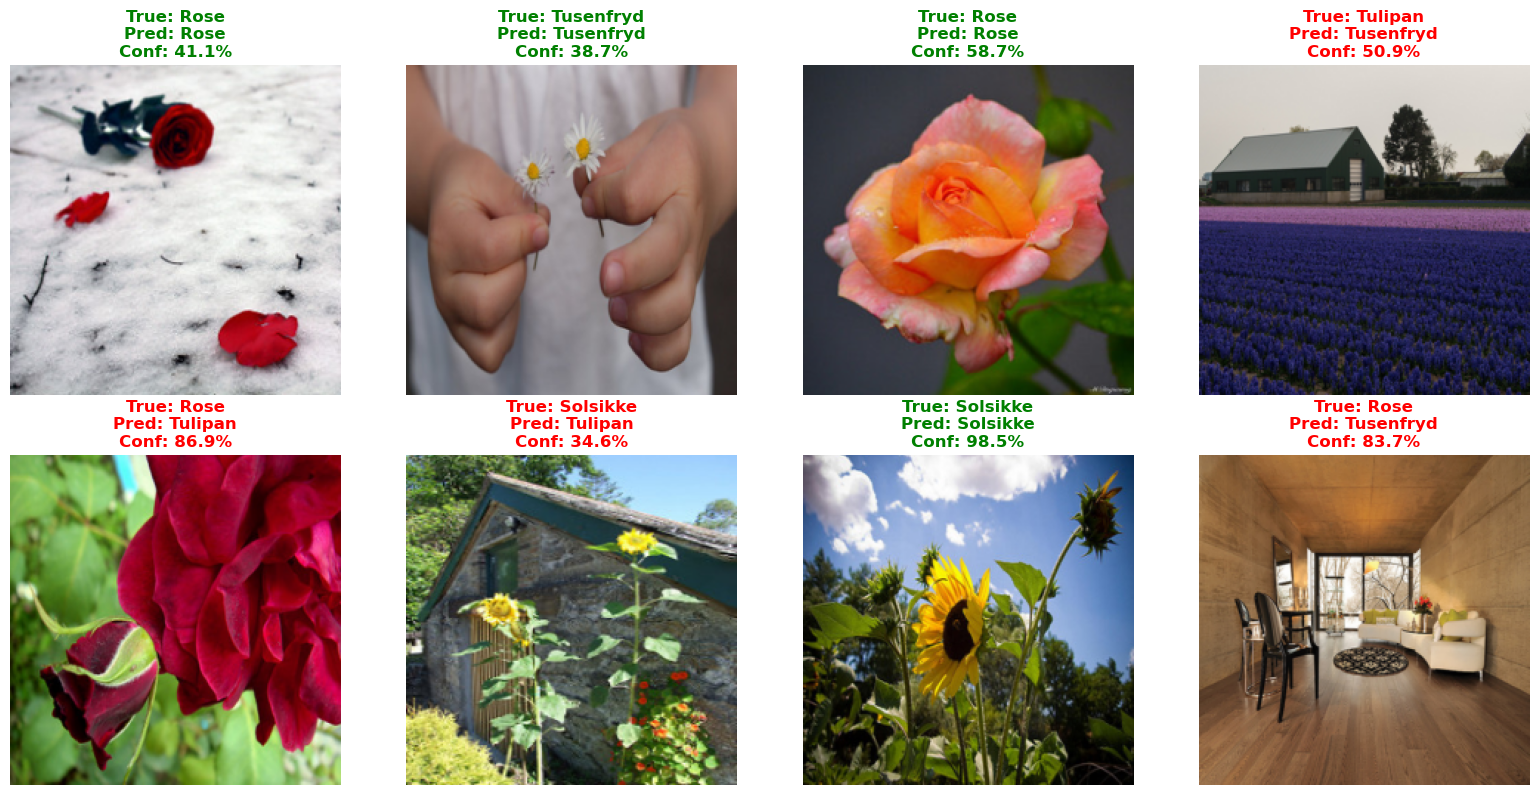


📊 Eksempel-prediksjoner:
  Korrekte prediksjoner: 4/8
  Accuracy på eksempler: 50.0%


In [13]:
def show_prediction_examples(model, test_loader, class_names, num_samples=8):
    """Vis eksempel-prediksjoner"""
    
    model.eval()
    
    # Hent en batch fra testsettet
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    # Ta bare de første num_samples bildene
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Gjør prediksjoner
    with torch.no_grad():
        images_gpu = images.to(device)
        outputs = model(images_gpu)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)
    
    # Konverter til CPU for visualisering
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()
    
    # Visualiser resultater
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Denormaliser bilde for visualisering
        img = images[i]
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        # Vis bilde
        axes[i].imshow(img.permute(1, 2, 0))
        
        # Få prediksjon og sannsynlighet
        pred_class = predicted[i].item()
        true_class = labels[i].item()
        confidence = probabilities[i][pred_class].item() * 100
        
        # Sett farge basert på korrekt prediksjon
        color = 'green' if pred_class == true_class else 'red'
        
        # Vis informasjon
        axes[i].set_title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}\nConf: {confidence:.1f}%", 
                         color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Vis statistikk
    correct = (predicted == labels).sum().item()
    accuracy = correct / num_samples * 100
    
    print(f"\n📊 Eksempel-prediksjoner:")
    print(f"  Korrekte prediksjoner: {correct}/{num_samples}")
    print(f"  Accuracy på eksempler: {accuracy:.1f}%")

# Vis eksempel-prediksjoner
show_prediction_examples(model, test_loader, class_names, num_samples=8)

## Sammenligning med medisinsk bildeanalyse

La oss sammenligne vår blomsterklassifikasjon med medisinsk bildeanalyse.

In [14]:
def compare_with_medical_imaging():
    """Sammenlign blomsterklassifikasjon med medisinsk bildeanalyse"""
    
    print("🏥 Sammenligning: Blomsterklassifikasjon vs Medisinsk Bildeanalyse")
    print("=" * 70)
    
    # Sammenligningstabell
    comparison_data = {
        'Aspekt': [
            'Datamengde',
            'Kompleksitet',
            'Konsekvenser',
            'Ekspertise',
            'Regulering',
            'Etiske aspekter',
            'Ytelse-krav',
            'Feil-toleranse'
        ],
        'Blomsterklassifikasjon': [
            'Tusener av bilder',
            'Farge, form, tekstur',
            'Estetisk verdi',
            'Botanikk',
            'Minimal',
            'Lav risiko',
            '80-90% accuracy',
            'Høy (feil er OK)'
        ],
        'Medisinsk Bildeanalyse': [
            'Begrenset (privacy)',
            'Anatomiske strukturer',
            'Frisk vs Syk',
            'Medisin/radiologi',
            'CE/MDR, FDA',
            'Høy risiko',
            '95-99% accuracy',
            'Lav (feil kan være farlig)'
        ]
    }
    
    # Print sammenligning
    for i, aspect in enumerate(comparison_data['Aspekt']):
        print(f"\n{aspect}:")
        print(f"  Blomster: {comparison_data['Blomsterklassifikasjon'][i]}")
        print(f"  Medisin:  {comparison_data['Medisinsk Bildeanalyse'][i]}")
    
    print("\n🔍 Felles prinsipper:")
    print("  - Begge bruker CNN-arkitektur")
    print("  - Begge krever domenekunnskap")
    print("  - Begge har problemer med ubalanserte klasser")
    print("  - Begge trenger robuste modeller")
    print("  - Begge har etiske implikasjoner")
    
    print("\n💡 Lærdommer:")
    print("  - Blomsterklassifikasjon er en god introduksjon til medisinsk AI")
    print("  - Samme teknikker kan brukes i begge domener")
    print("  - Medisinsk AI krever høyere ytelse og mer regulering")
    print("  - Etiske aspekter er viktigere i medisin")

# Sammenlign med medisinsk bildeanalyse
compare_with_medical_imaging()

🏥 Sammenligning: Blomsterklassifikasjon vs Medisinsk Bildeanalyse

Datamengde:
  Blomster: Tusener av bilder
  Medisin:  Begrenset (privacy)

Kompleksitet:
  Blomster: Farge, form, tekstur
  Medisin:  Anatomiske strukturer

Konsekvenser:
  Blomster: Estetisk verdi
  Medisin:  Frisk vs Syk

Ekspertise:
  Blomster: Botanikk
  Medisin:  Medisin/radiologi

Regulering:
  Blomster: Minimal
  Medisin:  CE/MDR, FDA

Etiske aspekter:
  Blomster: Lav risiko
  Medisin:  Høy risiko

Ytelse-krav:
  Blomster: 80-90% accuracy
  Medisin:  95-99% accuracy

Feil-toleranse:
  Blomster: Høy (feil er OK)
  Medisin:  Lav (feil kan være farlig)

🔍 Felles prinsipper:
  - Begge bruker CNN-arkitektur
  - Begge krever domenekunnskap
  - Begge har problemer med ubalanserte klasser
  - Begge trenger robuste modeller
  - Begge har etiske implikasjoner

💡 Lærdommer:
  - Blomsterklassifikasjon er en god introduksjon til medisinsk AI
  - Samme teknikker kan brukes i begge domener
  - Medisinsk AI krever høyere ytelse 

## Oppsummering og neste steg

### Hva vi har oppnådd:
- ✅ Lastet inn trent modell fra del 2
- ✅ Testet modellen på testsettet
- ✅ Evaluerte ytelse med forvirringsmatrise og metrikker
- ✅ Forstod modellens beslutninger med CAM
- ✅ Sammenlignet med medisinsk bildeanalyse

### Neste steg (del 4):
- Oppsummering og konklusjon
- Kunnskapsstoff om CNN i helse
- Litteratur og ressurser
- Veien videre

### Refleksjonsspørsmål:
1. **Hvorfor** er forvirringsmatrise viktig for å evaluere modeller?
2. **Hva** forteller CAM oss om modellens beslutningsprosess?
3. **Hvordan** kan vi bruke disse teknikker i medisinsk bildeanalyse?
4. **Hvorfor** er forklarbar AI viktig i helse?

---

**Gå videre til del 4: `C4-cnn-konklusjon.ipynb`**